In [19]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
using JWAS:misc               # utility functions
using Distributions       
using Plots                     # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [2]:
#using Pkg 
#Pkg.add(PackageSpec(name="JWAS",rev="master"))

In [5]:
phenotypes = CSV.read("Data_sp_reprod_per_parity1.csv",delim = ',',header=true, missingstring=".")
#phenotypes = phenotypes[1:100,:]
size(phenotypes)
varGen = CSV.read("gen_var_reprod.csv",delim = ',',header=true, missingstring=".")
varGen


,Trait,gen_corr,cov
,String,Float64,Float64
1,LiveBorn,0.47,0.08
2,TNB,0.87,0.07
3,log_SB,0.02,0.0006
4,log_MUM,0.01,-0.0033
5,log_NBD,0.02,0.001


In [6]:
 for i in 4
      for j in 22 #[ 22, 23, 24]
        varMY = 0.02
        trait1= names(phenotypes)[i]
        trait2= names(phenotypes)[j]
        phenotypes2 = dropmissing(phenotypes, i)
        phenotypes2 = dropmissing(phenotypes2, j)
        varRes=cov(Matrix(phenotypes2[:,[i, j]]))
        modelEquation = "$trait1 = intercept + Collection_Group + AnimalID
                         $trait2 = intercept + FarmID + FarrowDate + AnimalID"
        model2 = build_model(modelEquation,  varRes)
        set_random(model2,"FarrowDate",varMY)
        g = varGen[varGen[!,:Trait] .== "$trait2" ,:]
        gen_reprod = g[1,2]
        covs = g[1,3]
        gen_sp = 0.04
        SP_G = [gen_sp/2 covs/2 
                covs/2 gen_reprod/2]
        @time add_genotypes(model2,"Genotype_AnimalID_imputed_final_ASReml_order_numerical.mkr", SP_G ,header=true, separator=' ')
        pedigree = get_pedigree("Pedigree_clean_4gen",separator=",",header=false)
        set_random(model2,"AnimalID",pedigree,SP_G)
        IDs = JWAS.PedModule.getIDs(pedigree)
        outputEBV(model2,IDs;PEV=false)
        SP_outC=runMCMC(model2,phenotypes,methods="BayesC",single_step_analysis=true,
            pedigree=pedigree,chain_length=50000,burnin=5000,output_samples_frequency=1,
            output_heritability=true,output_samples_file="$(trait2)_SSGBLUP_initial2", missing_phenotypes=true, estimatePi=false)
    end 
end


FarrowDate is not found in model equation 1.
The delimiter in Genotype_AnimalID_imputed_final_ASReml_order_numerical.mkr is ' '.
The header (marker IDs) is provided in Genotype_AnimalID_imputed_final_ASReml_order_numerical.mkr.
45536 markers on 887 individuals were added.
  6.081986 seconds (1.64 M allocations: 996.784 MiB, 6.34% gc time)
The delimiter in Pedigree_clean_4gen is ','.
Finished!
Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
calculating A inverse
  0.051113 seconds (107.11 k allocations: 8.411 MiB, 54.64% gc time)
imputing missing genotypes
 41.796037 seconds (2.36 k allocations: 12.602 GiB, 3.36% gc time)
completed imputing genotypes

Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.

The prior for marker effects covariance matrix is calculated from genetic covariance matrix and Π.
The mean of the prior for the marker effects covariance matrix is:
 1.0e-6  0.0   
 0.0    

running MCMC for BayesC...100%|█████████████████████████| Time: 12:30:35




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-1680 v2 @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, ivybridge)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.




In [8]:
ebv1=CSV.read("log_SB_SSGBLUP_initial2_EBV_log_SB.txt", header = true)
genVar1 = var(Matrix(ebv1),dims=2)
ebv2=CSV.read("log_SB_SSGBLUP_initial2_EBV_SP_ratio.txt", header = true)
genVar2 = var(Matrix(ebv2),dims=2)
#first(ebv1,5) 
size(ebv1)

(50000, 6757)

In [22]:
ebv11 = mean(Matrix(ebv1), dims=1)
ebv22 = mean(Matrix(ebv2), dims=1)
cor(vec(ebv11), vec(ebv22))

1×6757 Array{Float64,2}:
 -0.0754317  -0.0237277  -0.00676667  …  -0.0683531  -0.0890334  -0.134033

In [28]:
ebv=CSV.read("log_SB_SSGBLUP_initial2_EBV_SP_ratio.txt", header = true)
first(ebv,5)
genVar = var(Matrix(ebv),dims=2)
mean(genVar)
#resVar = CSV.read("log_SB_SSGBLUP_initial_residual_variance.txt",header=true)
#h2 = [genVar[i]/(genVar[i] + resVar[i,1]) for i=1:size(genVar,1)]
#[mean(h2) std(h2)]

In [30]:
corr

50000-element Array{Float64,1}:
 0.40549290115386194
 0.5061602609993988 
 0.561885753640942  
 0.5315079248951099 
 0.5819043294163119 
 0.5779140589044596 
 0.5805205198361727 
 0.5941114907068415 
 0.5836224335900697 
 0.5862858673904331 
 0.5696141237591804 
 0.5538257229389696 
 0.5585234962395537 
 ⋮                  
 0.4915833266516943 
 0.4447887646728962 
 0.4759517870931921 
 0.5118295785991813 
 0.5312451326995699 
 0.49459095450890733
 0.5165596863251642 
 0.4858747769737252 
 0.5180475606620714 
 0.5194871108923781 
 0.481508104649963  
 0.464902264268296  

In [9]:
corr = zeros(size(ebv1,1))
for i = 1:size(ebv1,1)
    corr[i] = cor(vec(permutedims(Vector(ebv1[i,:]))), vec(permutedims(Vector(ebv2[i,:]))))
    end 
corr
r=mean(corr)
se_r = std(corr)
[r se_r]

1×2 Array{Float64,2}:
 0.571638  0.188234

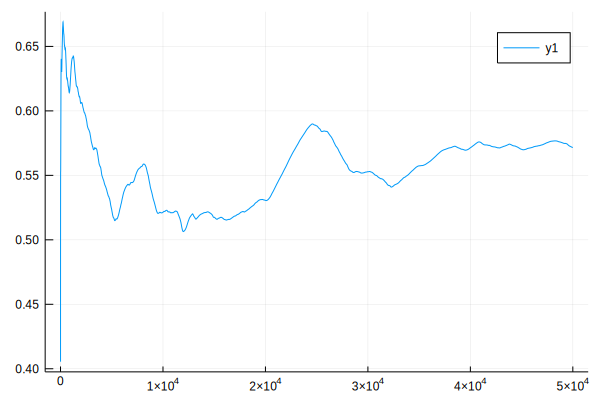

In [11]:
global rmean = 0.0
res = zeros(size(corr,1))
for (i,v) in enumerate(corr)
    rmean += v
    res[i] = rmean/i
end
plot(res)

In [32]:
gen=readtable("log_SB_SSGBLUP_initial_polygenic_effects_variance.txt", header = true)
res=readtable("log_SB_SSGBLUP_initial_residual_variance.txt", header = true)
[mean(gen[:,1]) mean(res[:,1])]
#[mean(gen[:,4]) mean(res[:,4])]


1×2 Array{Float64,2}:
 0.0289257  0.113775

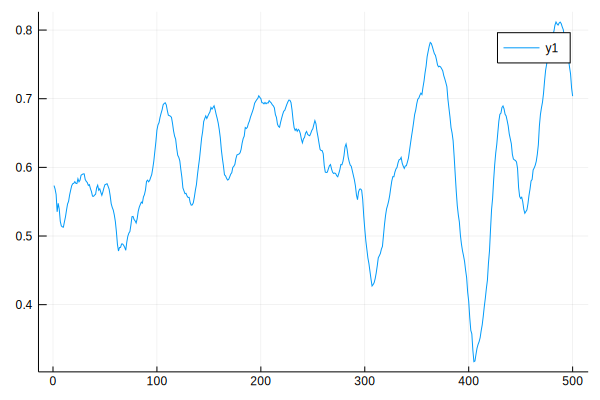

In [291]:
using RollingFunctions
roll_mean = runmean(corr, 20)
plot(roll_mean)

In [193]:
a = readtable("EBV_TNB.txt", header = true)
[mean(vec(ebv11)) mean(vec(ebv22)) mean(a[:,2])]

1×3 Array{Float64,2}:
 0.0342597  0.021046  0.0342597

In [194]:
size(a)

(6757, 3)